In [1]:
%matplotlib inline

import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import os
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.autograd import Variable

from __future__ import print_function

from PIL import Image

from utils import *

import sys; sys.argv=['']; del sys

** Sepcify parameters **

In [2]:
# Training settings

parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
parser.add_argument('--batch-size', type=int, default=64, metavar='N',
                    help='input batch size for training (default: 64)')
parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                    help='input batch size for testing (default: 1000)')
parser.add_argument('--epochs', type=int, default=10, metavar='N',
                    help='number of epochs to train (default: 10)')
parser.add_argument('--lr', type=float, default=0.005, metavar='LR',
                    help='learning rate (default: 0.01)')
parser.add_argument('--decay', type=float, default=0.00001, metavar='LR',
                    help='learning rate (default: 0.00001)')
parser.add_argument('--momentum', type=float, default=0.5, metavar='M',
                    help='SGD momentum (default: 0.5)')
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='disables CUDA training')
parser.add_argument('--seed', type=int, default=1, metavar='S',
                    help='random seed (default: 1)')
parser.add_argument('--log-interval', type=int, default=10, metavar='N',
help='how many batches to wait before logging training status')

args = parser.parse_args()
args.cuda = not args.no_cuda and torch.cuda.is_available()

torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)

kwargs = {'num_workers': 1, 'pin_memory': True} if args.cuda else {}

** Define Model and Optimizer **

In [3]:

from vgg import *

model = VGG('VGG19')
arch = 'VGG19'

if args.cuda:
    model.cuda()

** Define optimizer **

In [4]:
optimizer = optim.Adadelta(model.parameters())

** Load pre-trained model **

In [5]:
model_path = 'models/model_best_99.38.pkl'

print("=> loading checkpoint '{}'".format(model_path))
checkpoint = torch.load(model_path)
args.start_epoch = checkpoint['epoch']
best_prec1 = checkpoint['best_prec1']
model.load_state_dict(checkpoint['state_dict'])
model.eval()
optimizer.load_state_dict(checkpoint['optimizer'])
print("=> loaded checkpoint '{}' (epoch {}) (accuracy {})"
      .format(model_path, checkpoint['epoch'], checkpoint['best_prec1']))

=> loading checkpoint 'models/model_best_99.38.pkl'
=> loaded checkpoint 'models/model_best_99.38.pkl' (epoch 30) (accuracy 99.3796114274)


** Implement CRF post processing **

In [6]:
import sys
import numpy as np
import cv2
import pydensecrf.densecrf as dcrf
import matplotlib.pylab as plt
from skimage.segmentation import relabel_sequential
from pydensecrf.utils import softmax_to_unary


from pydensecrf.utils import compute_unary, create_pairwise_bilateral, \
    create_pairwise_gaussian
    
def crf_postprocess(image,seg_mask,use_2d):    
    
    (x,y) = np.nonzero(np.sum(image!=15,axis=2))
    top_left_x, top_left_y = x[0],y[0]
    bottom_right_x, bottom_right_y = x[-1],y[-1]

    img = image[top_left_x:bottom_right_x,top_left_y:bottom_right_y,:]
    mask = seg_mask[top_left_x:bottom_right_x,top_left_y:bottom_right_y]
    
    # img = image[0].transpose((1,2,0))
    labels = relabel_sequential(mask)[0].flatten().astype('uint8') + 1


    M = 21 # 21 Classes to match the C++ example

    # Example using the DenseCRF class and the util functions
    d = dcrf.DenseCRF(img.shape[0] * img.shape[1], M)
    
    # get unary potentials (neg log probability)
    U = compute_unary(labels, M, GT_PROB=0.5)
    d.setUnaryEnergy(U)

    # This creates the color-independent features and then add them to the CRF
    feats = create_pairwise_gaussian(sdims=(23, 23), shape=img.shape[:2])
    d.addPairwiseEnergy(feats, compat=3,
                        kernel=dcrf.DIAG_KERNEL,
                        normalization=dcrf.NORMALIZE_SYMMETRIC)

    # This creates the color-dependent features and then add them to the CRF
    feats = create_pairwise_bilateral(sdims=(100, 100), schan=(5, 5, 5),
                                      img=img, chdim=2)
    d.addPairwiseEnergy(feats, compat=10,
                        kernel=dcrf.DIAG_KERNEL,
                        normalization=dcrf.NORMALIZE_SYMMETRIC)

    Q = d.inference(20)
    map = np.argmax(Q, axis=0).reshape(img.shape[:2])

    res = (map.astype('float32') * 255 / map.max() > 0).astype('float32')
   
    crf_mask = np.zeros((image.shape[:2]))
    crf_mask[top_left_x:bottom_right_x,top_left_y:bottom_right_y] = res

    crf_seg_img = np.multiply(image,np.transpose(np.tile(crf_mask,(3,1,1)),(1,2,0))).astype('uint8')
    
    return (crf_mask,crf_seg_img)


### Run CNN+CRF segmentation on one image

In [7]:
box_side = 50
img_path  = '../Data/Test/Images/frame001.png'
gt_mask_path    = '../Data/Test/Ground_Truth/frame001.png'

image = np.asarray(Image.open(img_path))
gt_mask = np.asarray(Image.open(gt_mask_path)) > 0

seg_mask,seg_img = get_predict(model,image,box_side)

crf_mask,crf_seg_img = crf_postprocess(image,seg_mask,False)
       
       

### Plot segmented masks

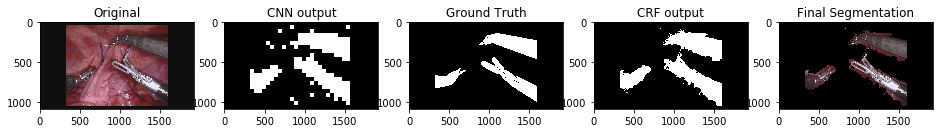

In [11]:
plt.figure(figsize=(16, 12))
plt.subplot(151)
plt.title('Original')
plt.imshow(image)
plt.subplot(152)
plt.title('CNN output')
plt.imshow(seg_mask,cmap='gray')
plt.subplot(153)
plt.title('Ground Truth')
plt.imshow(gt_mask,cmap='gray')
plt.subplot(154)
plt.title('CRF output')
plt.imshow(crf_mask,cmap='gray')
plt.subplot(155)
plt.title('Final Segmentation')
plt.imshow(crf_seg_img,cmap='gray')

### evaluate IOU

In [12]:
print('CNN output IOU {}'.format(IOU(gt_mask,seg_mask)))
print('CRF output IOU {}'.format(IOU(gt_mask,crf_mask)))

CNN output IOU 0.576912358606
CRF output IOU 0.703252109656
